# Homework 2: Imbalanced Classification (by SLT)
**Deadline:** October 20, 11:59PM.

**Instructions:**
In this homework, you will be given a flexibility to choose a dataset you want to work on. For reference, you may use the answers of the cohort in the earlier exercise, see [link](https://docs.google.com/presentation/d/1uXrwW7yz4VBLxoZMbwtdtU2sf0z-OeK0FyB5EHU4L5Q/edit?usp=sharing).

The sections below are provided as guide on how you can structure your work to meet the minimum requirements for this homework, which are:
1. Brief description of the data: objective, data dictionary, minimal EDA relevant to the objective.
2. `automl` results using default hyperparameters of `sklearn` classifiers, use an appropriate metric beginning at this step. Include a brief (1-2 sentences) discussion of the chosen metric.
3. A confusion matrix for the chosen classifier from the above step, include a brief discussion of the matrix.
4. Perform 3 resampling techniques (excluding, Random Oversampling and Random Undersampling)
    * SMOTE (required)
    * ADASYN (required)
    * A technique not discussed in class
*Note: You may use the* `imblearn` *implementations instead of the function provided during the lecture*

5. Re-run our `automl` (default model hyperparameters) using the resampled training data. Comment on the differences.

6. *Optional:* You may choose to tune your resampling parameters (e.g. $\beta$, $K$) and show sensitivity plots for additional $Angas^{TM}$ points.


**Some Flexibilities you can take advantage of:**
* `StratifiedKFold` number of folds
* The classifiers you wish to use (minimum of 3)
* Size of the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Brief Description of the Dataset Used

In [2]:
# insert code here
# absolute_path = os.path.abspath("C:\\Users\\JG\\jupyter directory\\datasets\\adult.csv")
df = pd.read_csv("C:\\Users\\JG\\jupyter directory\\datasets\\adult.csv")
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


*Discuss here*

## Preprocessing

In [3]:
df = df.applymap(lambda x: x.strip() if type(x) == str else x).applymap(lambda x: np.nan if x=='?' else x)
df = df.dropna(subset=['workclass', 'occupation', 'native-country'], axis=0)
df = df.drop(['education'], axis=1)
dummies = pd.concat([pd.get_dummies(df['workclass']), 
                     pd.get_dummies(df['marital-status']),
                     pd.get_dummies(df['occupation']),
                     pd.get_dummies(df['relationship']),
                     pd.get_dummies(df['race']),
                     pd.get_dummies(df['native-country'])], axis=1)
df = pd.concat([df, dummies], axis=1).drop(['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'native-country'], axis=1)
df['target'] = df['class'].apply(lambda x: 0 if x=='<=50K' else 1)
df = df.drop(['class'], axis=1)
df['sex'] = df['sex'].apply(lambda x: 1 if x=='Male' else 0)
df

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,Federal-gov,Local-gov,Private,...,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,target
0,25,226802,7,1,0,0,40,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,38,89814,9,1,0,0,50,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,28,336951,12,1,0,0,40,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,44,160323,10,1,7688,0,40,0,0,1,...,0,0,0,0,0,0,1,0,0,1
5,34,198693,6,1,0,0,30,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,257302,12,0,0,0,38,0,0,1,...,0,0,0,0,0,0,1,0,0,0
48838,40,154374,9,1,0,0,40,0,0,1,...,0,0,0,0,0,0,1,0,0,1
48839,58,151910,9,0,0,0,40,0,0,1,...,0,0,0,0,0,0,1,0,0,0
48840,22,201490,9,1,0,0,20,0,0,1,...,0,0,0,0,0,0,1,0,0,0


0 : <=50k <br>1: >50K

0    0.752156
1    0.247844
Name: target, dtype: float64


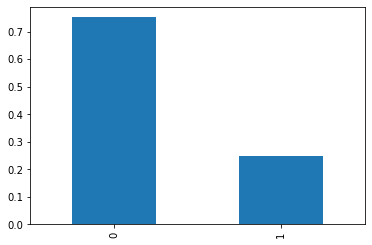

In [4]:
df['target'].value_counts(normalize=True).plot(kind='bar')
print(df['target'].value_counts(normalize=True))

In [5]:
pcc = df['target'].value_counts(normalize=True)**2
np.sum(pcc)*1.25

0.7839566589795592

## `automl` Default runs

In [6]:
X = df.drop('target', axis=1)
y = df['target']
feature_names = X.columns

In [7]:
# insert code here
from sklearn.model_selection import train_test_split, StratifiedKFold
(X_trainval, X_test, y_trainval, y_test) = train_test_split(X, y, 
                                           random_state=11, test_size=0.25, 
                                           stratify=y)

## Chosen Metric : F1 Score

<b>Why F1 score?</b>
> insert explanation

In [8]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score


models_dict = {
    'LogisticRegressor': LogisticRegression(random_state=11, max_iter=1_000_000),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'RandomForestClassifier': RandomForestClassifier(random_state=11),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=11)   
}


skf = StratifiedKFold(n_splits=5)

def automl(X, y):
# insert code here
    res = {}
    for model_name, model in models_dict.items():
        model_start = time.time()
        train_scores = []
        val_scores = []
        test_scores = []
        for train_index, val_index in skf.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]


            model.fit(X_train, y_train)

            y_pred_train = model.predict(X_train)

            train_score = f1_score(y_train, y_pred_train)


            y_pred_val = model.predict(X_val)
            val_score = f1_score(y_val, y_pred_val)

            train_scores.append(train_score)
            val_scores.append(val_score)

            y_pred_test = model.predict(X_test)
            test_score = f1_score(y_test, y_pred_test)
            test_scores.append(test_score)

        model_end = time.time() - model_start
        res[model_name] = {
            'ave_train_f1':np.mean(train_scores) * 100,
            'ave_val_f1':np.mean(val_scores) * 100,
            'ave_test_f1': np.mean(test_scores) * 100,
            'runtime': model_end
        }

        print(f'{model_name}: done')
    df = pd.DataFrame(res).T
    return df


In [9]:
automl(X_trainval, y_trainval)

LogisticRegressor: done
KNeighborsClassifier: done
RandomForestClassifier: done
GradientBoostingClassifier: done


,ave_train_f1,ave_val_f1,ave_test_f1,runtime
LogisticRegressor,38.750893,38.785491,39.217862,1.534866
KNeighborsClassifier,56.841616,40.758603,40.272325,120.894758
RandomForestClassifier,99.982154,67.927802,67.610432,22.737620
GradientBoostingClassifier,69.397957,68.672316,69.793739,26.892451


*Discuss here*

## Confusion Matrix

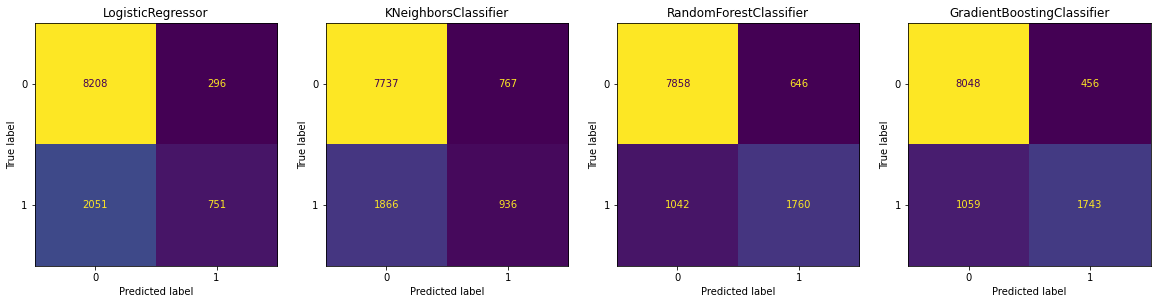

In [10]:
# insert code here
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

i = 0
for model_name, model in models_dict.items():
    
    model.fit(X_trainval, y_trainval)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(model_name, fontsize=12)

    i += 1


*Discuss here*

## Resampling

In [11]:
# insert code here
from imblearn.over_sampling import SMOTE 
sm = SMOTE(sampling_strategy=1.0, random_state=11)
X_smote, y_smote = sm.fit_resample(X_trainval, y_trainval)

In [12]:
from imblearn.over_sampling import ADASYN 
ada = ADASYN(sampling_strategy=1.0, random_state=11)
X_ada, y_ada = ada.fit_resample(X_trainval, y_trainval)

In [13]:
from imblearn.under_sampling import TomekLinks 
tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(X_trainval, y_trainval)

## Resampled data `automl` results

<b>SMOTE</b>

In [14]:
automl(X_smote, y_smote)

LogisticRegressor: done
KNeighborsClassifier: done
RandomForestClassifier: done
GradientBoostingClassifier: done


,ave_train_f1,ave_val_f1,ave_test_f1,runtime
LogisticRegressor,51.402569,51.734418,41.971078,2.380800
KNeighborsClassifier,82.042231,73.207026,44.109765,319.515908
RandomForestClassifier,99.995100,87.153584,67.197143,60.957911
GradientBoostingClassifier,89.332308,87.183486,69.857533,66.323655


<b>ADASYN</b>

In [15]:
automl(X_ada, y_ada)

LogisticRegressor: done
KNeighborsClassifier: done
RandomForestClassifier: done
GradientBoostingClassifier: done


,ave_train_f1,ave_val_f1,ave_test_f1,runtime
LogisticRegressor,52.777790,54.902736,43.902509,3.538628
KNeighborsClassifier,80.478972,68.536038,44.150818,340.548072
RandomForestClassifier,99.995494,86.617580,66.737211,57.410447
GradientBoostingClassifier,89.212702,87.143186,69.899301,62.344707


<b>TomekLinks</b>

In [16]:
automl(X_tl, y_tl)

LogisticRegressor: done
KNeighborsClassifier: done
RandomForestClassifier: done
GradientBoostingClassifier: done


,ave_train_f1,ave_val_f1,ave_test_f1,runtime
LogisticRegressor,43.318917,42.918197,42.042029,2.132930
KNeighborsClassifier,61.241466,45.472196,41.457339,105.576011
RandomForestClassifier,99.980667,70.998689,68.800825,22.355552
GradientBoostingClassifier,72.924608,72.090350,70.952225,25.360719


*Discuss here*

## Sensitivity

Focus on GBM

### Beta

In [17]:
model = GradientBoostingClassifier(random_state=11)
beta_list = np.arange(0.4, 1.1, 0.1)
score_list = []
runtime_list = []
for b in beta_list:
    start = time.time()
    sm = SMOTE(sampling_strategy=b, random_state=11)
    X_smote, y_smote = sm.fit_resample(X_trainval, y_trainval)
    
    model.fit(X_smote, y_smote)
    y_pred = model.predict(X_test)
    test_f1 = f1_score(y_test, y_pred)
    
    score_list.append(test_f1)
    print(b)
    end = time.time() - start
    runtime_list.append(end)
df_beta = pd.DataFrame([score_list, runtime_list], columns=beta_list, index=['f1', 'runtime'])
df_beta

0.4
0.5
0.6
0.7
0.7999999999999999
0.8999999999999999
0.9999999999999999


,0.4,0.5,0.6,0.7,0.8,0.9,1.0
f1,0.704489,0.702443,0.704652,0.700459,0.704206,0.702003,0.700136
runtime,8.778524,9.260290,10.123500,11.001451,10.975852,11.534048,13.048174


### K_neighbors

In [18]:
k_list = range(2,30,2)
score_list = []
runtime_list = []
for k in k_list:
    start = time.time()
    sm = SMOTE(sampling_strategy=1.0, random_state=11, k_neighbors=k)
    X_smote, y_smote = sm.fit_resample(X_trainval, y_trainval)
    
    model.fit(X_smote, y_smote)
    y_pred = model.predict(X_test)
    test_f1 = f1_score(y_test, y_pred)
    score_list.append(test_f1)
    print(k)
    end = time.time() - start
    runtime_list.append(end)
df_k = pd.DataFrame([score_list, runtime_list], index=['F1', 'runtime'], columns=k_list)
df_k

2
4
6
8
10
12
14
16
18
20
22
24
26
28


,2,4,6,8,10,12,14,16,18,20,22,24,26,28
F1,0.702215,0.703519,0.699677,0.698738,0.699898,0.699437,0.699303,0.698709,0.698007,0.699558,0.699899,0.698016,0.698586,0.696070
runtime,12.704511,11.592000,11.255286,11.751406,11.220328,12.214281,11.829807,12.456937,12.093152,11.161168,11.186928,11.101988,11.209893,11.260985
